In [2]:
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter
import sys

from covid19model.data.model_parameters import get_integrated_willem2012_interaction_matrices, get_COVID19_SEIQRD_parameters
from covid19model.models.utils import read_coordinates_nis

agg = 'arr'
initN, Nc_all, _, _ = get_COVID19_SEIQRD_parameters(spatial='arr')

In [3]:
def add_scalebar(ax, xy, length=50000., numdiv=5, fac="km", lw=5.,
                 marg=1000.):
    """
    Add a scalebar to the plot, using plot data units.

    Parameters
    -----------
    ax : mpl.axis
        current axis to scale bar
    xy : tuple of float
        x and y-coordinates of the lower left point of the scalebar, in map units
    lenght : float
        length in map units (m) of the scalebar
    numdiv : int
        number if division to split scalebar
    fac : str
        currently, only km for kilometer is supported
    lw : float
        width/length ratio
    marg : float
        distance between text and rectangles in map units
    """
    from itertools import cycle
    from matplotlib.patches import Rectangle

    # calculate left lower coordinates of rectangles
    x_pos = [xy[0] + i*length/numdiv for i in range(numdiv)]
    y = xy[1]
    # calculate labels
    dlabels = [int(i*length/numdiv/1000.) for i in range(numdiv + 1)]
    #put rectangles on the map
    for x, dlab, c in zip(x_pos, dlabels, cycle(['black', 'white'])):
        rect = Rectangle((x, y), length/numdiv,
                         length/numdiv/lw, facecolor=c, edgecolor='k',
                         zorder=10)
        ax.add_patch(rect)
        #ax.text(x_pos, y_pos + length/numdiv/lw + marg, dlab,
        #         horizontalalignment='center')
    #add last label
    #ax.text(ll_x_pos[-1] + length/numdiv, y_pos + length/numdiv/lw + marg,
    #         dlabels[-1], horizontalalignment='center')
    #put unit on it
#     if not fac=="km":
#         raise Exception('Only km as unit supported.')
#     else:
    ax.text(x_pos[-1] + length/numdiv + marg, y + length/numdiv/lw/2.,
                fac, horizontalalignment='left',
                verticalalignment='center', zorder=10)

In [4]:
def add_north_arrow(ax, xy, yheight=0.05, xwidth=0.04, marg=0.01):
    """
    Add a north arrow to the plot, using relative Axes units

    Parameters
    -----------
    ax : mpl.axis
        current axis to add north arrow
    xy : tuple of 2 floats
        x and y-coordinates of the top point of the north arrow, in relative axes units
    yheigth : float
        distance in map units between the top point and the moddle point of
        the arrow
    xwidth : float
        width of the arrow in map units
    marg : float
        distance between text and rectangles in map units
    """
    from matplotlib.patches import Polygon

    x_a, y_a = xy

    #add north arrow
    ylow = np.sqrt(yheight**2 - xwidth**2)

    #triangles to make north arrow
    rpol = Polygon(np.array([[x_a, y_a] ,[x_a, y_a - yheight],
                   [x_a + xwidth/2., y_a - yheight - ylow]]),
                   facecolor='w', edgecolor='k', transform=ax.transAxes,
                   zorder=10)
    ax.add_patch(rpol)
    lpol = Polygon(np.array([[x_a, y_a] ,[x_a, y_a - yheight],
                   [x_a - xwidth/2., y_a - yheight - ylow]]),
                   facecolor='k', edgecolor='k', transform=ax.transAxes,
                   zorder=10)
    ax.add_patch(lpol)

    # N text
    ax.text(x_a, y_a + marg, "N", horizontalalignment='center',
            transform=ax.transAxes, zorder=10)


In [5]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", show_xlabel=True, show_ylabel=True, show_colorbar=True, vmin=None, vmax=None, ticks=None):

    if not ax:
        ax = plt.gca()
        
    if not vmin:
        vmin = np.min(data)
    if not vmax:
        vmax = np.max(data)

    # Plot the heatmap
    im = ax.imshow(data, norm=colors.LogNorm(vmin=vmin, vmax=vmax))

    # Create colorbar
    if show_colorbar:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="8%", pad=0.2)
        formatter = LogFormatter(10, labelOnlyBase=False)
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=ticks, format=formatter, cax=cax)# **cbar_kw) #fraction=0.046, pad=0.04, **cbar_kw)
#         cbar.set_label(cbarlabel, fontsize=12)
        cbar.ax.set_yticklabels([2000, 10000, 100000, 200000])
        # cbar.ax.set_ylabel(cbarlabel, rotation=270, fontsize=15, labelpad=15) #, va="bottom"
        # cbar = ax.figure.colorbar(im, ax=ax, fraction=0.0001, pad=0.04, **cbar_kw, rotation=270, fontsize = 15, labelpad=15)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    if show_xlabel:
        ax.set_xticklabels(col_labels)
    else:
        ax.set_xticklabels([None]*len(col_labels))
    if show_ylabel:
        ax.set_yticklabels(row_labels)
    else:
        ax.set_yticklabels([None]*len(row_labels))

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # Rotate the tick labels and set their alignment.
    matplotlib.pyplot.setp(ax.get_xticklabels(), rotation=-90, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    if show_colorbar:
        return im, cbar
    else:
        return im

<IPython.core.display.Javascript object>


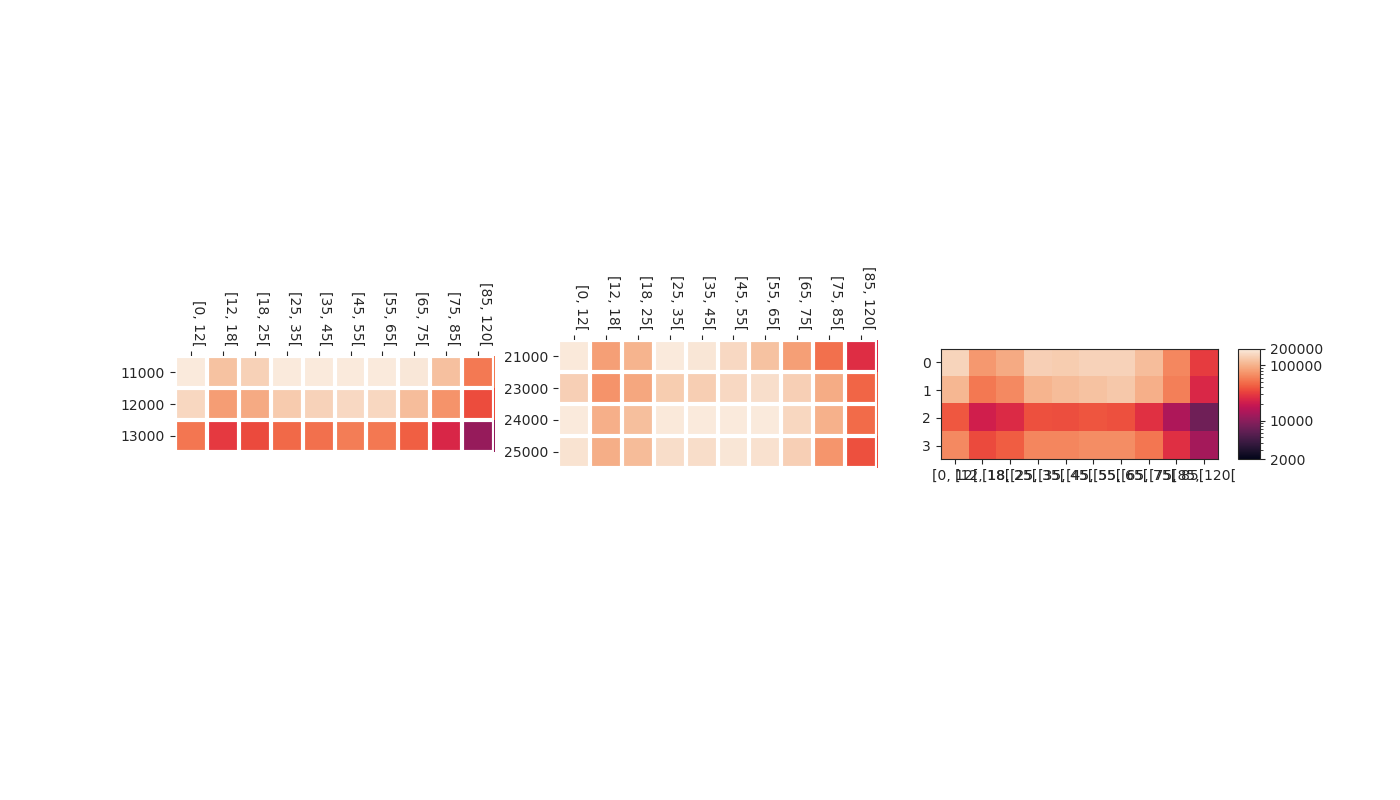

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (36).

In [6]:
(G, N) = initN.shape

row_labels = read_coordinates_nis(spatial=agg)
row_labels0 = row_labels[:G//3]
initN0 = initN.values[:G//3,:]
row_labels1 = row_labels[G//3:2*G//3]
initN1 = initN.values[G//3:2*G//3,:]
row_labels2 = row_labels[2*G//3:]
initN2 = initN.values[2*G//3:,:]
# column_labels = np.array(['[0, 10[', '[10, 20[', '[20, 30[', '[30, 40[', '[40, 50[', '[50, 60[', '[60, 70[', '[70, 80[', '[80, inf['])
column_labels = np.array(['[0, 12[', '[12, 18[', '[18, 25[', '[25, 35[', '[35, 45[', '[45, 55[', '[55, 65[', '[65, 75[', '[75, 85[', '[85, 120['])


fig, axs = plt.subplots(1, 3, figsize=(14, 8))
vmin=2000
vmax=200000
ticks=[2000, 10000, 100000, 200000]
heatmap(initN0, row_labels0, column_labels, ax=axs[0], vmin=vmin, vmax=vmax, show_colorbar=False)
heatmap(initN1, row_labels1, column_labels, ax=axs[1], vmin=vmin, vmax=vmax, show_colorbar=False)
heatmap(initN2, row_labels2, column_labels, ax=axs[2], vmin=vmin, vmax=vmax, ticks=ticks)

# plt.savefig('pop_per_arr.png', dpi=400, bbox_inches='tight')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator


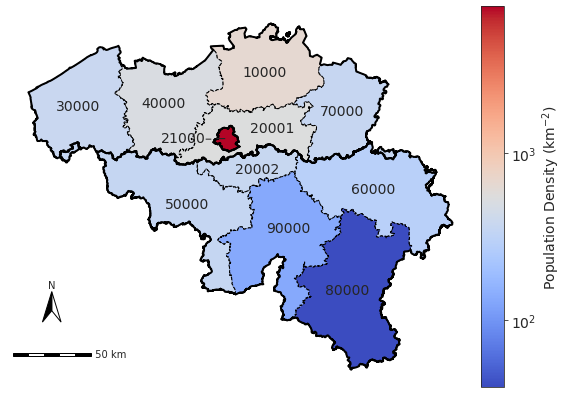

In [8]:
# Data analysis package, numerical package, plotting package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use datetime format in indices
import datetime

import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics

# Import nice colors for plotting
from matplotlib import colors

# Import operation system module to create directories
import os

# reload initN
initN, Nc_all, _, _ = get_COVID19_SEIQRD_parameters(spatial='prov')


# Load different geographical aggregations
country = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_6_Country.shp")
regions = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_5_Region.shp")
provinces = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_4_Province.shp")
arrondissements = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_3_District.shp")
municipalities = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_2_Municipality.shp")

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Add Dutch names
provinces.loc[provinces['NISCode'] == 'NA', 'NameDut'] = 'Brussel'
provinces.loc[provinces['NISCode'] == '20002', 'NameDut'] = 'Waals-Brabant'
provinces.loc[provinces['NISCode'] == '60000', 'NameDut'] = 'Luik'
provinces.loc[provinces['NISCode'] == '80000', 'NameDut'] = 'Luxemburg'
provinces.loc[provinces['NISCode'] == '90000', 'NameDut'] = 'Namen'

# Show different geographical aggregations on the same axes
# ax = municipalities.plot(figsize = (12,7), color='none', edgecolor = 'whitesmoke')
# ax = arrondissements.plot(figsize = (12,7), color='none', edgecolor = 'lightgrey')
# arrondissements.plot(color='none', edgecolor = 'lightgrey', ax=ax)
# ax = provinces.plot(figsize = (12,7), color='none', edgecolor = 'k')
# regions.plot(color='none', edgecolor = 'k', ax=ax)
# country.plot(color='none', edgecolor = 'k', ax=ax)
# ax.set_axis_off()

# Define density
provinces = provinces.merge(initN.sum(axis=1).to_frame().reset_index().astype(str), left_on='NISCode', right_on='NIS')
provinces = provinces.drop(columns=['NIS'])
initN.sum(axis=1).to_frame().reset_index().astype(str)
provinces = provinces.rename(columns={0 : "population"})
provinces['density'] = provinces['population'].astype(int)/provinces['Shape_Area']*1e6

# Make figure
fig, ax = plt.subplots(figsize = (12,7)) # 1200 pixels x 1200 pixels
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
cax.set_ylabel("will-be-overwritten", size=14)
cax.set_yticklabels('will-be-overwritten', size=14)
ax.set_axis_off()

vmin = provinces.density.min()
vmax = provinces.density.max()
fig = provinces.plot(column='density', ax=ax, cmap='coolwarm',
                            legend=True, edgecolor = 'k', linestyle='--', norm=colors.SymLogNorm(1e2, vmin=vmin, vmax=vmax), cax=cax,
                            legend_kwds={'label': "Population Density (km$^{-2}$)"})

regions.plot(color='none', edgecolor = 'k', linewidth=2, ax=ax)

textsize=14
ax.text(660000, 710000, '10000', size=textsize)
ax.text(665000, 674000, '20001', size=textsize)
ax.text(655000, 648000, '20002', size=textsize)
ax.text(607000, 668000, '21000–', size=textsize)
ax.text(540000, 688000, '30000', size=textsize)
ax.text(595000, 690000, '40000', size=textsize)
ax.text(610000, 625000, '50000', size=textsize)
ax.text(730000, 635000, '60000', size=textsize)
ax.text(710000, 685000, '70000', size=textsize)
ax.text(713000, 570000, '80000', size=textsize)
ax.text(675000, 610000, '90000', size=textsize)

add_north_arrow(ax, (0.0955, 0.25))
add_scalebar(ax, (512000, 530000), length=50000, fac=' 50 km')


# fig = ax.get_figure()
# fig.savefig('provinces-with-NIS-regions-density', bbox_inches='tight', dpi=400)

In [64]:
provinces

,ModifDate,NISCode,tgid,Shape_Leng,Shape_Area,NameDut,NameFre,NameGer,Fictitious,geometry,population,density
0,2007-01-05,21000,{82D5952D-83FE-47B7-B364-86C06F4CBF05},72160.956955,1.624199e+08,None,None,None,1,"POLYGON Z ((644970.934 666620.967 0.000, 64496...",1218255,7500.653379
1,2007-01-05,10000,{929F5D3C-E10D-47A7-9CDC-83F4AF3A96EE},408827.722211,2.876121e+09,Antwerpen,None,None,0,"MULTIPOLYGON Z (((689484.397 733088.371 0.000,...",1869730,650.087469
2,2007-01-05,70000,{C6D8398C-ABAE-482A-8023-B0F542BF33AE},398143.091319,2.427429e+09,Limburg,Limbourg (le),None,0,"MULTIPOLYGON Z (((754408.942 657294.967 0.000,...",877370,361.440056
3,2007-01-05,40000,{1A97609D-ED74-41DB-9558-74D89E0980EE},404317.296515,3.007076e+09,Oost-Vlaanderen,Flandre orientale (la),None,0,"POLYGON Z ((588115.516 661182.001 0.000, 58811...",1525255,507.221999
4,2007-01-05,20001,{858254C1-E262-4E9F-A531-392BB2997638},508210.593035,2.118348e+09,Vlaams-Brabant,Brabant flamand (le),None,0,"POLYGON Z ((702188.307 657189.213 0.000, 70215...",1155843,545.634067
5,2007-01-05,30000,{9DFB14E3-9D32-4AAA-9C4E-9145782A420A},357077.955130,3.196576e+09,West-Vlaanderen,Flandre occidentale (la),None,0,"POLYGON Z ((542253.829 659434.082 0.000, 54226...",1200945,375.697302
6,2007-01-05,20002,{244F51C9-A8D9-4F2F-BB0F-E0DADAF92EBC},285854.641445,1.097180e+09,Waals-Brabant,Brabant wallon (le),None,0,"POLYGON Z ((634227.446 647350.579 0.000, 63422...",406019,370.056922
7,2007-01-05,50000,{2305D752-653B-4328-AA32-8F52909822D1},679094.173367,3.813035e+09,Henegouwen,Hainaut (le),None,0,"MULTIPOLYGON Z (((544991.813 655934.106 0.000,...",1346840,353.219899
8,2007-01-05,60000,{6185E8D3-5EFA-48BB-AA1F-7E54A787C9C4},574895.151401,3.857112e+09,Luik,LiÃ¨ge,LÃ¼ttich,0,"POLYGON Z ((711501.296 625901.656 0.000, 71141...",1109800,287.728191
9,2007-01-05,80000,{716C6254-F3A1-4123-BD2C-8D8C35989229},542484.495962,4.459250e+09,Luxemburg,Luxembourg,None,0,"POLYGON Z ((696165.658 576434.729 0.000, 69616...",286752,64.304982


In [70]:
arrondissements = arrondissements.merge(initN.sum(axis=1).to_frame().reset_index().astype(str), left_on='NISCode', right_on='NIS')
arrondissements = arrondissements.drop(columns=['NIS'])

initN.sum(axis=1).to_frame().reset_index().astype(str)

arrondissements = arrondissements.rename(columns={0 : "population"})
arrondissements['density'] = arrondissements['population'].astype(int)/arrondissements['Shape_Area']*1e6

<AxesSubplot:>

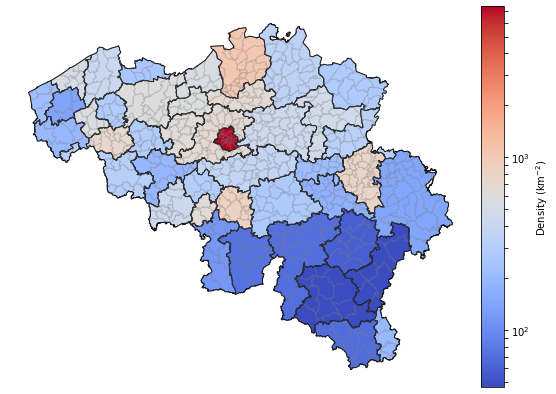

In [86]:
# Make figure
fig, ax = plt.subplots(figsize = (12,7)) # 1200 pixels x 1200 pixels
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
ax.set_axis_off()

vmin = arrondissements.density.min()
vmax = arrondissements.density.max()
fig = arrondissements.plot(column='density', ax=ax, cmap='coolwarm',
                            legend=True, edgecolor = 'k', norm=colors.SymLogNorm(1, vmin=vmin, vmax=vmax), cax=cax,
                            legend_kwds={'label': "Density (km$^{-2}$)"})

municipalities.plot(color='none', edgecolor='grey', ax=ax, alpha=0.2)
# textbox = 'Days of delay to ' + prov + '\nHospitalised per 100k'
# plt.figtext(.15, .30, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
# plt.close()

# (Create directory and) save figure
# path = '../figures/maps/provinces/time_series_tests/'
# chart = fig.get_figure()
# chart.savefig('time-delays_prov_to_' + prov + '.jpg' ,dpi=50, bbox_inches='tight')

In [89]:
initN, Nc_all, _, _ = get_COVID19_SEIQRD_parameters(spatial='mun')

municipalities = municipalities.merge(initN.sum(axis=1).to_frame().reset_index().astype(str), left_on='NISCode', right_on='NIS')
municipalities = municipalities.drop(columns=['NIS'])

initN.sum(axis=1).to_frame().reset_index().astype(str)

municipalities = municipalities.rename(columns={0 : "population"})
municipalities['density'] = municipalities['population'].astype(int)/municipalities['Shape_Area']*1e6

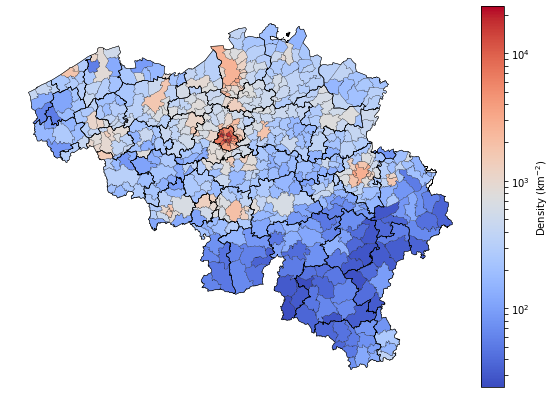

In [99]:
# Make figure
fig, ax = plt.subplots(figsize = (12,7)) # 1200 pixels x 1200 pixels
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
ax.set_axis_off()

vmin = municipalities.density.min()
vmax = municipalities.density.max()
fig = municipalities.plot(column='density', ax=ax, cmap='coolwarm', linewidth=0.2,
                            legend=True, edgecolor = 'k', norm=colors.SymLogNorm(1, vmin=vmin, vmax=vmax), cax=cax,
                            legend_kwds={'label': "Density (km$^{-2}$)"})

arrondissements.plot(color='none', edgecolor='k', ax=ax, linewidth=0.5)
# textbox = 'Days of delay to ' + prov + '\nHospitalised per 100k'
# plt.figtext(.15, .30, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
# plt.close()

# (Create directory and) save figure
# path = '../figures/maps/provinces/time_series_tests/'
chart = fig.get_figure()
# chart.savefig('population-densities_mun.jpeg' ,dpi=400, bbox_inches='tight')